In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
BIDS_path = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\f_band_features_concatenated\LM_100ms'

In [2]:
def get_movement_idx(ch, mov_channels, Con=True):
    """returns index of mov_channels given boolean Con and ch
    
    Arguments:
        ch {string} -- given channel string
        mov_channels {list} -- string list of used movement channels including LEFT or RIGHT
    
    Keyword Arguments:
        Con {bool} -- laterality (default: {True})
    
    Returns:
        int -- index of mov_channel of the lateral channel
    """
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

# fs is 10 Hz; estimate the mean +-1 s around the movements
def calc_epochs_f_bands(dat_filtered, y_tr, threshold, epoch_lim):
     
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    filtered_epoch = np.zeros([ind_mov.shape[0], int(epoch_lim*2), dat_filtered.shape[0]])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim*2)])
    #print(ind_mov)
    for idx, i in enumerate(ind_mov):
        filtered_epoch[idx,:,:] = dat_filtered[:,i-epoch_lim:i+epoch_lim].T
        y_arr[idx,:] = y_tr[i-epoch_lim:i+epoch_lim]

    return filtered_epoch, y_arr

def get_dat(Con = True, ECOG_=True):
    dat_filtered = []
    for subject_id_ in subject_id:
        with open(out_path+'\\sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        for ch in list(dict_ch.keys()):
            if (ECOG_ is True and 'ECOG' in ch) or (ECOG_ is False and 'STN' in ch):
                dat_ = np.array(dict_ch[ch]['data'])
                mov_dat = np.array(dict_ch[ch]['true_movements'][get_movement_idx(ch, dict_ch[ch]['mov_ch'], Con=Con)])
                X_epoch, y_epoch = calc_epochs_f_bands(dat_, mov_dat, threshold=0, epoch_lim=20)
                dat_filtered.append(np.mean(X_epoch, axis=0))
    return np.array(dat_filtered)


def get_burst_length(
    beta_averp_norm,
    beta_thr,
    sfreq=250,
    return_burst_amplitude=False,
    return_burst_indexes=True
):
    """
    Characterization of beta bursts: Analysing the duration of beta burst 
    """
    deriv = np.diff (beta_averp_norm >= beta_thr)
    isburst = False
    burst_length = []
    burst_start = 0
    burst_amplitude = []
    burst_indexes = []

    for index, i in enumerate(deriv):
        if i == True:
            if isburst == True:
                burst_length.append(index - burst_start)
                burst_amplitude.append(beta_averp_norm[burst_start:index].mean())
                isburst = False
            else:
                burst_start = index
                isburst = True
    burst_length = np.array(burst_length)/sfreq
    
    if return_burst_amplitude:
        return burst_length, np.array(burst_amplitude)
    if return_burst_indexes:
        return burst_length, burst_indexes
    return burst_length



In [3]:
subject_id_ = "013"

ECOG_=False
THR_REST=False
beta_names=["low_beta"]#, "high_beta", "all_beta"]


with open(out_path+'\\sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
    dict_ch = json.load(fp)

for ch in list(dict_ch.keys()):
    dat_ch = np.array(dict_ch[ch]['data'])
    if (ECOG_ is True and 'ECOG' in ch) or (ECOG_ is False and 'STN' in ch):

        label_ = np.stack(dict_ch[ch]["true_movements"])

        mov_ = np.logical_or(
                label_[0,:]>0.1,
                label_[1,:]>0.1
        )

        rest_ = np.logical_and(
                label_[0,:]<0.1,
                label_[1,:]<0.1
        )

        mov_start = np.where(
            np.array(
                np.array(mov_[1:], dtype=int)-np.array(mov_[:-1],dtype=int)
            ) > 0
        )[0]

        mov_end = np.where(
            np.array(
                np.array(mov_[1:], dtype=int)-np.array(mov_[:-1],dtype=int)
            ) < 0
        )[0]

        for beta_idx, beta_name in zip([2,3,4,], beta_names):

            dat_burst_calc = dat_ch[beta_idx, :]

            if THR_REST is True:
                thr = np.percentile(dat_ch[beta_idx, rest_], q=75)
            else:
                thr = np.percentile(dat_burst_calc, q=75)

            time_in_burst_minus_3_1 = []
            time_in_burst_minus_1_0 = []
            time_in_burst_0_1 = []

            for idx_mov, mov_seg in enumerate(mov_start[:-1]):
                time_in_burst_minus_3_1.append(
                    np.array(np.array(dat_burst_calc[mov_seg-30:mov_seg-10])>thr).sum()
                )

                time_in_burst_minus_1_0.append(
                    np.array(np.array(dat_burst_calc[mov_seg-10:mov_seg])>thr).sum()
                )

                time_in_burst_0_1.append(
                    np.array(np.array(dat_burst_calc[mov_seg:mov_seg+10])>thr).sum()
                )

            # get burst times during movement

            try:
                per = df.query(f'ch == @ch and sub == {int(subject_id_)}')["r2_con"].iloc[0]
            except:
                continue

            if subject_id_ not in dict_out:
                dict_out[subject_id_] = {}
            if ch not in dict_out[subject_id_]:
                dict_out[subject_id_][ch] = {}
            if beta_name not in dict_out[subject_id_][ch]:
                dict_out[subject_id_][ch][beta_name] = {}

            dict_out[subject_id_][ch][beta_name]["r2_con"] = per

            per = df.query(f'ch == @ch and sub == {int(subject_id_)}')["r2_ips"].iloc[0]

            dict_out[subject_id_][ch][beta_name]["r2_ips"] = per

            dict_out[subject_id_][ch][beta_name]["time_in_burst_minus_3_1"] = np.array(
                time_in_burst_minus_3_1
            ).mean()

            dict_out[subject_id_][ch][beta_name]["time_in_burst_minus_1_0"] = np.array(
                time_in_burst_minus_1_0
            ).mean()

            dict_out[subject_id_][ch][beta_name]["time_in_burst_0_1"] = np.array(
                time_in_burst_0_1
            ).mean()

In [4]:
rate_000 = []
for mov_point in mov_start:
    rate_000.append(np.array(dat_burst_calc>thr)[mov_point-10:mov_point+10])


In [5]:
rate_013 = []
for mov_point in mov_start:
    arr = np.array(dat_burst_calc>thr)[mov_point-10:mov_point+10]
    if arr.shape[0] != 0:
        rate_013.append(arr)


In [19]:
d = {
    "sub000" : np.array(rate_000),
    "sub013" : np.array(rate_013)
}
scipy.io.savemat("waterfall_bursts.mat", d)

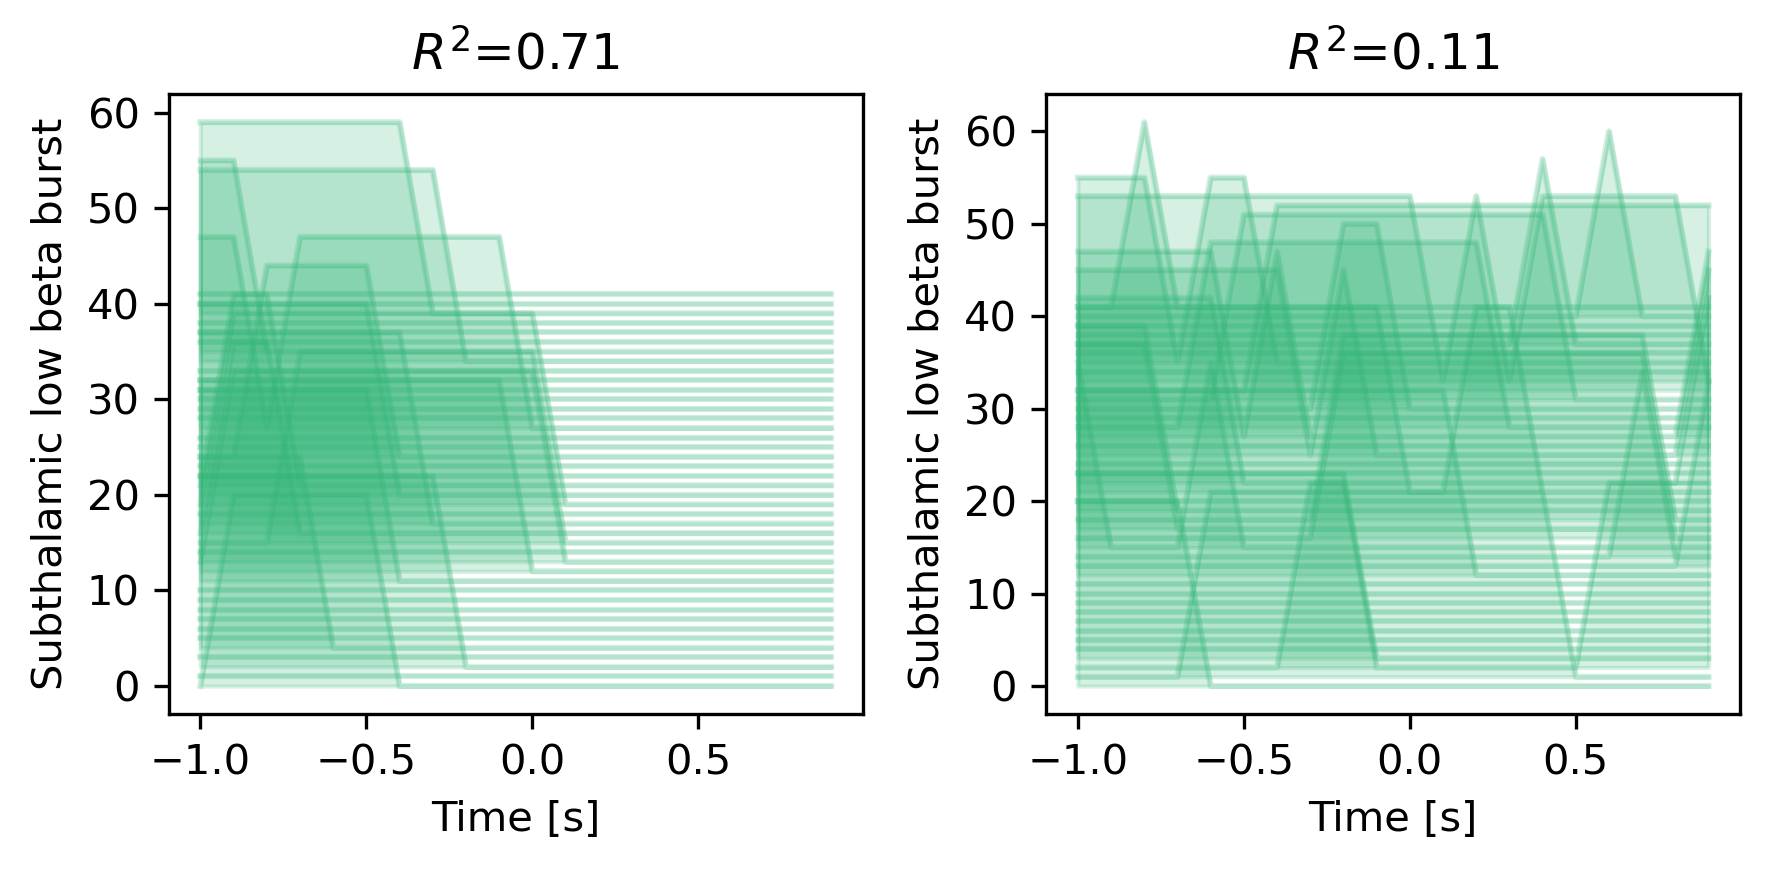

In [7]:
plt.figure(figsize=(6,3), dpi=300)
plt.subplot(121)
x_ = np.arange(-1, 1, 0.1)
for i in range(len(rate_000)):
    plt.plot(x_, i+20*rate_000[i], alpha=0.2, color=(53/255,183/255,121/255))
    plt.fill_between(x_, i+20*np.zeros(20), i+20*rate_000[i], color=(53/255,183/255,121/255), alpha=0.2)
plt.xlabel("Time [s]")
plt.ylabel("Subthalamic low beta burst")
plt.title(r"$R^2$"+"=0.71")

plt.subplot(122)
for i in range(len(rate_000)):
    plt.plot(x_, i+rate_013[i]*20, alpha=0.2, color=(53/255,183/255,121/255))
    plt.fill_between(x_, i+np.zeros(20)*20, i+rate_013[i]*20, color=(53/255,183/255,121/255), alpha=0.2)
        
plt.xlabel("Time [s]")
plt.ylabel("Subthalamic low beta burst")

plt.title(r"$R^2$"+"=0.11")
plt.tight_layout()

plt.savefig("Point 2 - Burst comparison Good Bad.pdf", bbox_inches='tight', dpi=300)


C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_16668/3662133724.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


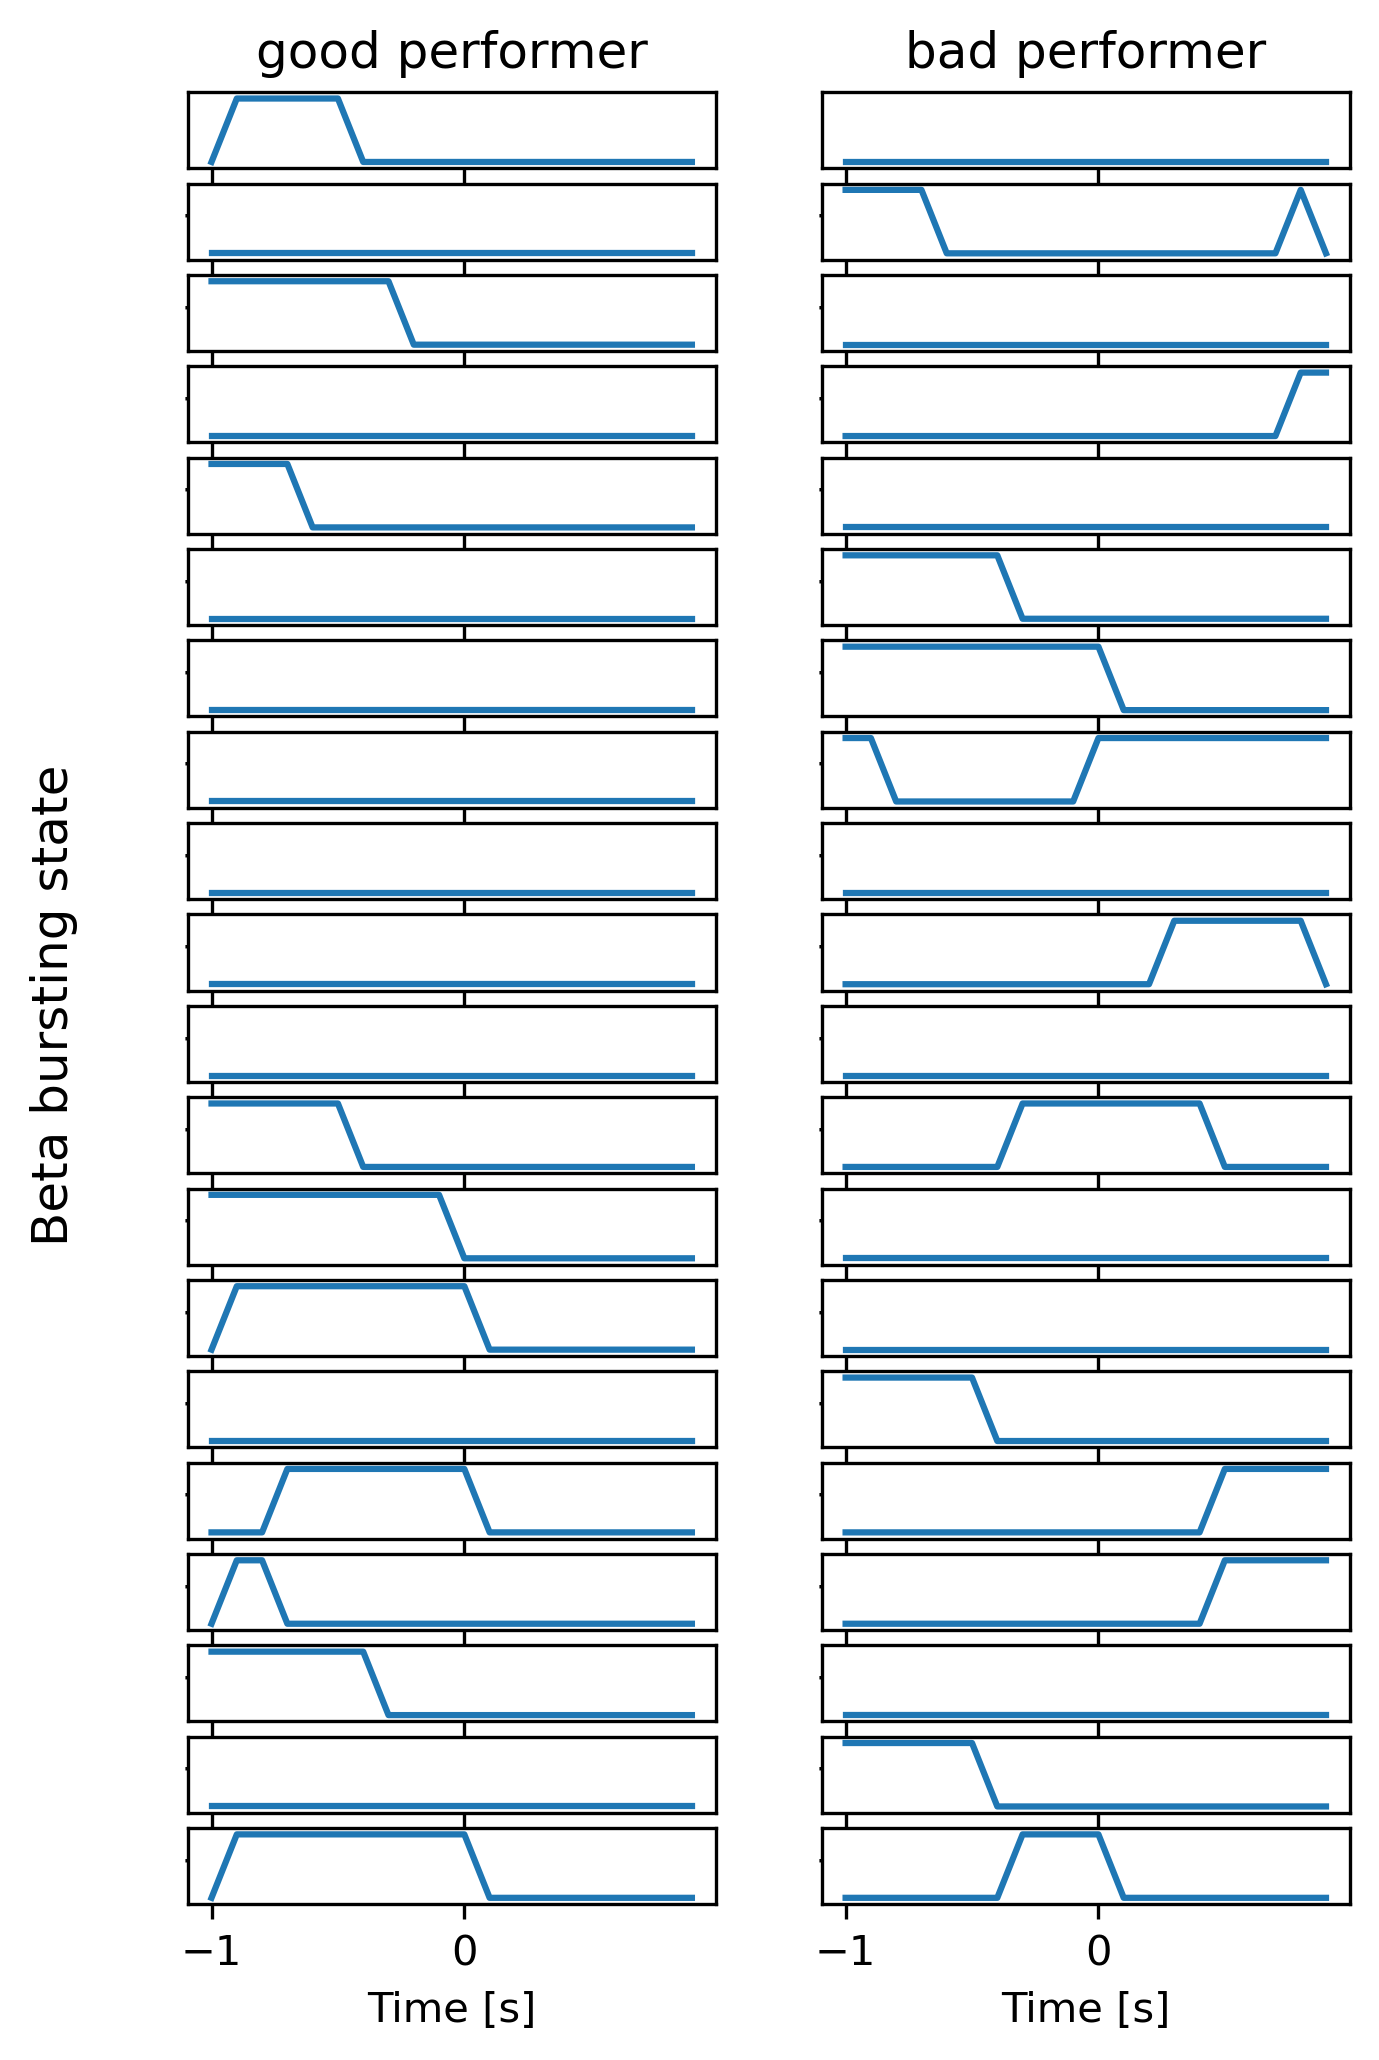

In [27]:
fig = plt.figure(figsize=(5, 8), dpi=300)
idx = 1
x_ = np.arange(-1, 1, 0.1)
for i in range(20):
    plt.subplot(20, 2, idx)
    idx += 1
    plt.plot(x_, rate_000[i])
    if i==0:
        plt.title("good performer")
    if i== 19:
        plt.xlabel("Time [s]")
    plt.ylim(-0.1, 1.1)
    plt.yticks(color='w')
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)

    
    plt.subplot(20, 2, idx)
    idx +=1
    plt.plot(x_, rate_007[i])
    if i==0:
        plt.title("bad performer")
    if i==19:
        plt.xlabel("Time [s]")
    plt.ylim(-0.1, 1.1)
    plt.yticks(color='w')
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)

fig.supylabel('Beta bursting state')

plt.tight_layout()

In [10]:
io.savemat('burst_above_thr.mat', {
    "sub000" : np.vstack(rate_000),
    "sub007" : np.vstack(rate_007)
})


Text(0.5, 1.0, 'Good and bad ECoG performer\nBursting probability')

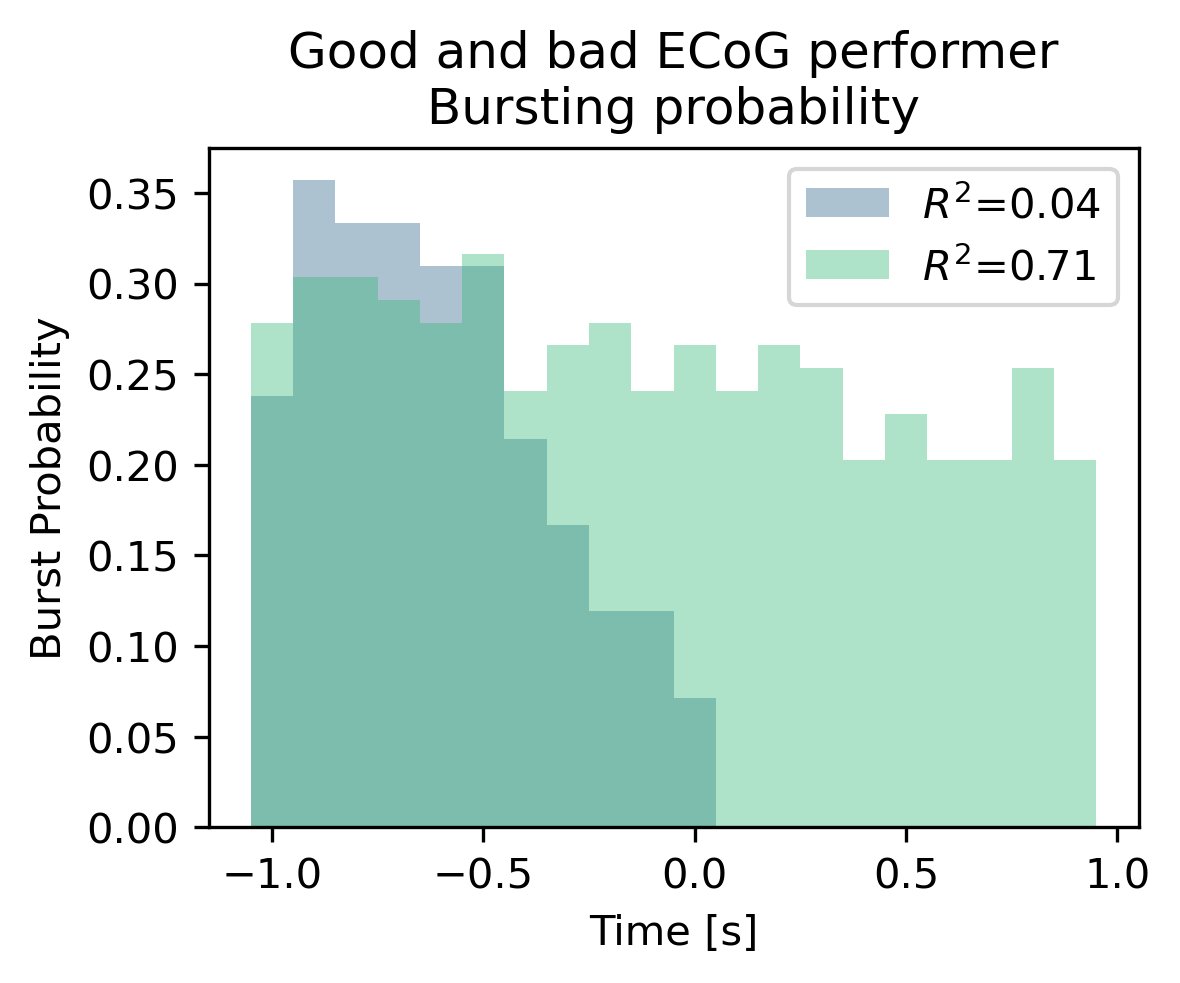

In [89]:
plt.figure(figsize=(4,3), dpi=300)
x_ = np.arange(-1, 1, 0.1)
plt.bar(x_, np.stack(rate_000).sum(axis=0)/len(rate_000),
        width=0.1, color=(49/255,104/255,142/255), alpha=0.4, label=r"$R^2$"+"=0.04")
plt.bar(x_, np.stack(rate_007).sum(axis=0)/len(rate_007),
        width=0.1, color=(53/255,183/255,121/255), alpha=0.4, label=r"$R^2$"+"=0.71")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Burst Probability")
plt.title("Good and bad ECoG performer\nBursting probability")

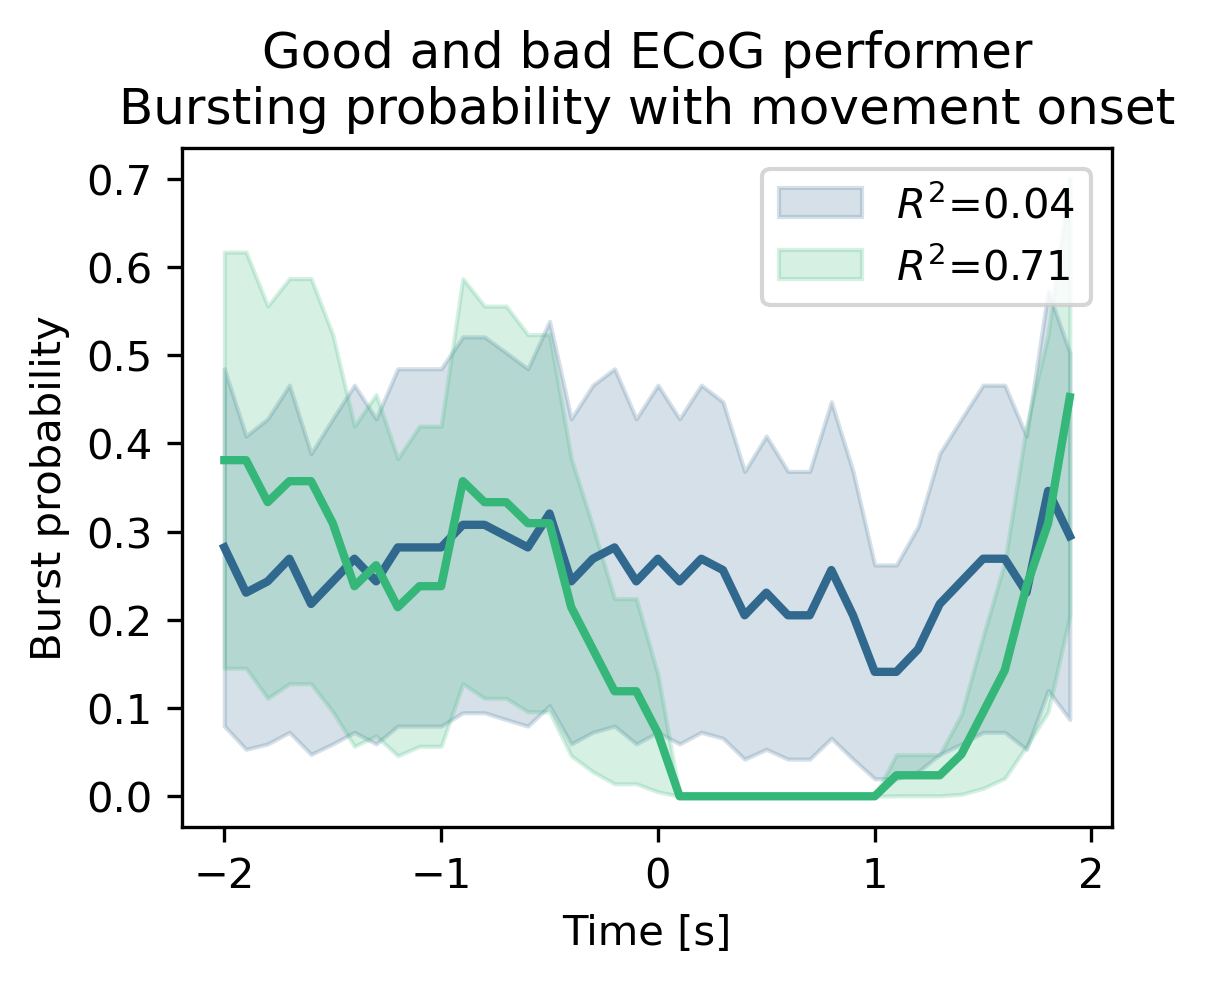

In [64]:
plt.figure(figsize=(4,3), dpi=300)
mean_ = np.stack(rate_007).mean(axis=0)
var_ = np.stack(rate_007).var(axis=0)

plt.fill_between(x_, mean_-var_, mean_+var_, color=(49/255,104/255,142/255), alpha=0.2, label=r"$R^2$"+"=0.04")
plt.plot(x_, mean_, linewidth=2, color=(49/255,104/255,142/255))

mean_ = np.stack(rate_000).mean(axis=0)
var_ = np.stack(rate_000).var(axis=0)

plt.fill_between(x_, mean_-var_, mean_+var_, color=(53/255,183/255,121/255), alpha=0.2, label=r"$R^2$"+"=0.71")
plt.plot(x_, mean_, linewidth=2, color=(53/255,183/255,121/255))
plt.ylabel("Burst probability")
plt.xlabel("Time [s]")
plt.title("Good and bad ECoG performer\nBursting probability with movement onset")
plt.legend()
plt.savefig("Point 2 - Burst Rate Probability comparison Good Bad.pdf", bbox_inches='tight', dpi=300)

